In [2]:
import hitdifferentparts
import IPython.display as ipd
import numpy as np
import autograd
import torch
from kymatio import Scattering1D

from torch.autograd import backward
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

##  Reconstruction schemes: (regression from scattering to sounds)

choice of J 

choice of cost function

choice of optimizer

interpolate (0.45,0.5) from 4 adjacent points

In [135]:
N = 2**16 #length of auido signal
J = 4
def getsc(y, J):
    """
    this function outputs scattering transform of a time-domain signal.
    """
    N = len(y)
    scattering = Scattering1D(J = J,shape=(N,))
    Sy = scattering(y)
    return Sy

def interpolate_sounds(x_coord,y_coord,num,prec,J):
        """
        x_coord, y_coord is the point at which you want to interpolate the sounds
        num is number of interpolation points
        prec is distance between interpolated to interpolation points
        """
        scs = []
        sounds = []
        if num == 2:
            inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord)]
        elif num == 4:
            inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord),(x_coord,y_coord+prec),(x_coord,y_coord-prec)]
        for (x,y) in inter:
            y = hitdifferentparts.hitdiffparts(x,y)
            Sy = getsc(torch.Tensor(y),J)
            sounds.append(y)
            scs.append(Sy)
        return sum(scs)/float(num),sounds

In [3]:
Sc_interpolated,sounds = interpolate_sounds(0.45,0.5,4,0.05,J)

--- 1.4113969802856445 seconds ---
--- 1.9900736808776855 seconds ---
--- 1.8488178253173828 seconds ---
--- 1.8732571601867676 seconds ---


In [75]:
def normalize(S):
    #normalize tensor S to be within 0 to 1 range and sums up to 1
    min_S = torch.min(S)
    range_S = torch.max(S) - min_S
    if range_S > 0:
        S_normalized = (S - min_S) / range_S
        S_sum = torch.sum(S_normalized)
        S_normalized = S_normalized / S_sum #to make sure the probabilities adds up to 1 
    else:
        S_normalized = torch.zeros(S.size())
    return S_normalized,S_sum, min_S, range_S

def revert_normalize(S_normalized,S_sum,min_S,range_S):
    S = min_S + (S_normalized*S_sum) * range_S 
    return S
    

In [181]:
def normalize(S):
    S_relu = 1e-6 + torch.nn.functional.relu(S)
    return S_relu / torch.norm(S_relu)

In [150]:
Sc_normalized,Sc_sum,min_Sc,range_Sc = normalize(Sc_interpolated)
Sc_back = revert_normalize(Sc_normalized, Sc_sum,min_Sc,range_Sc)
print(torch.sum(Sc_normalized),torch.sum(Sc_interpolated),torch.sum(Sc_back-Sc_interpolated))

ValueError: too many values to unpack (expected 4)

In [154]:
def normalize_alt(S):
    #make sure tensors are all positive - remove negative values or shift all values towards positive?
    S_pos = S - torch.min(S)
    #normalize by L2 norm of tensor, which is equivalent as L2 norm of the sounds according to some thm?
    S_normalized = (S_pos / torch.norm(S,p=2))**2
    return S_normalized
    

In [215]:
Sy = normalize(Sc_interpolated)
x = torch.randn((N,),requires_grad=True)
Sx = normalize(Scattering1D(J=J,shape=(N,))(x))
err = torch.sum(Sx * torch.log((Sx / Sy)))
print(err)
#loss = torch.nn.KLDivLoss(reduction='batchmean')

#loss(torch.log(Sx), torch.log(Sy))


tensor(139.7151, grad_fn=<SumBackward0>)


In [214]:
x = torch.randn((N,),requires_grad=True)
Sx = normalize(Scattering1D(J=J,shape=(N,))(x))
y = torch.randn((N,),requires_grad=True)
Sy = normalize(Scattering1D(J=J,shape=(N,))(y))

err = torch.sum(Sx * torch.log((Sx / Sy)))
print(err)

tensor(0.9858, grad_fn=<SumBackward0>)


In [216]:
def regress_signal(
        s_c, N, J,
        learning_rate=0.1,
        momentum=0.0,
        NAG = False,
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.5,
        n_iterations=100,
        cost = "mse",
        verbose=False):
    """
    this function finds time-domain signal from scattering transform
    input: scattering tranform tensor, length of the signal(implicitly), learning rate and number of iterations
    output: time-domain signal represented in a tensor
    """
    scattering = Scattering1D(J=J,shape=(N,)) #N is length of signal, J is number of scales
    if cost == "cross-entropy":
        loss = torch.nn.KLDivLoss(reduction='batchmean')
    
    #random guess
    x = torch.randn((N,),requires_grad=True)
    Sx = scattering(x)
    #target
    Sy = s_c
    history = []
    signal_update = 0*x #

    #normalize Sy
    #Sy_normalized,Sy_sum,min_Sy,range_Sy = normalize(Sy) # Sy is the target
    Sy_normalized = normalize(Sy)
    
    #iterate to regress random guess to be close to target
    for it_id in tqdm_notebook(range(n_iterations), disable=not verbose):
        # Backpropagation
        if cost == "mse":
            err = torch.norm(Sx-Sy)
            #backward(torch.norm(Sx - Sy))
        elif cost == "cross-entropy":
            #Sy = Sy.long()
            #np.sum(yHat * np.log((yHat / y)))
            #normalize Sx and Sy - tensor values should always be 0-1 due to nature of cross entropy (correlation between probabilities)
            #Sx_normalized,Sx_sum,min_Sx,range_Sx = normalize(Sx) 
            Sx_normalized = normalize(Sx)
            err = torch.sum(Sx_normalized * torch.log((Sx_normalized / Sy_normalized)))
            #err = loss(torch.log(Sx_normalized), torch.log(Sy_normalized))
            print(err,torch.norm(Sx_normalized,p=2),torch.norm(Sy_normalized,p=2))
            #backward(loss(Sx, Sy))         
        backward(err)
        if NAG == False:
            delta_x = x.grad 
    
        else:
            # for some reasons this nag doesn't have gradient!
            nag_x = torch.tensor(momentum * signal_update + x, requires_grad = True)
            print(nag_x.grad,nag_x)
            delta_x = nag_x.grad
            print(delta_x)
            
        #print(x.grad)

        # Gradient descent
        with torch.no_grad():
            momentum = min(0.99,1-2**(-1-np.log(np.floor(it_id/250)+1)/np.log(2))) #according to paper, adaptive momentum
            signal_update = momentum * signal_update - delta_x * learning_rate
            new_x = x + signal_update
        new_x.requires_grad = True

        # New forward propagation
        Sx = scattering(new_x)
        # Measure the new loss
        history.append(err)
        
        if history[it_id]> history[it_id-1]:
            learning_rate *= bold_driver_brake
        else:
            learning_rate *= bold_driver_accelerator
            x = new_x
        #print(torch.norm(Sx - Sy))
        
        #print("lr = {:6.3f}     loss={:6.3f}".format(learning_rate, history[-1]))
    #Sx_back = revert_normalize(Sx_normalized, Sy_sum,min_Sy,range_Sy)
    return x,history

problem with KLD:

1. For KLD to be positive, the two tensors Sx and Sy should be between 0 and 1 and sums up to 1. And "The K-L divergence is only defined if P and Q both sum to 1 and if Q(i) > 0 for any i such that P(i) > 0."
2. what is the proper way of normalizing Sx? right now i'm doing scale into 0 to 1 range and normalize sum to 1. Is it valid? (the KLD is negative), sum up to 1 step makes everything in the tensor very small
3. have to consider how to revert normalized Sx back to its original? if the approximated x recovers the probability distribution of normalized Sy then does it necessarily represent a good waveform?
4. not symmetric https://en.wikipedia.org/wiki/Kullback–Leibler_divergence thus does not work as a distance metric?

In [173]:
torch.nn.KLDivLoss(reduction='batchmean')(torch.log(normalize(Sc_interpolated)), torch.log(normalize(Sc_interpolated)))

tensor(0.)

A Jupyter Widget

tensor(139.8168, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(125.1813, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(103.1843, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(82.6345, grad_fn=<SumBackward0>) tensor(1., grad_fn=<NormBackward0>) tensor(1.0000)
tensor(65.1427, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(52.9141, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(44.2591, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(38.7616, grad_fn=<SumBackward0>) tensor(1., grad_fn=<NormBackward0>) tensor(1.0000)
tensor(33.8995, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(30.6887, grad_fn=<SumBackward0>) tensor(1.0000, grad_fn=<NormBackward0>) tensor(1.0000)
tensor(27.6420, grad_fn=<SumBackward0>) tensor(1.0000, 

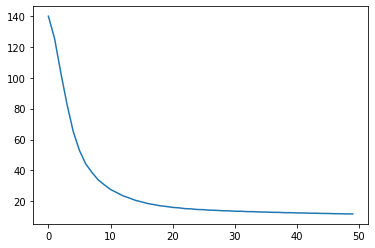

In [217]:
#test with KL
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.9, 
    NAG = False,
    n_iterations=50, 
    cost = "cross-entropy", 
    verbose=True)
plt.plot(history)

## Optimizer choice
MSE loss - find hyperparam that optimizes the regression

J = 4

hyper params:
1. bold driver accelerator = 1.1
2. bold driver brake = 0.55
3. learning rate = 100
4. momentum = 0.6 / adaptive according to paper


A Jupyter Widget

Text(0.5, 1.0, '4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 0.9')

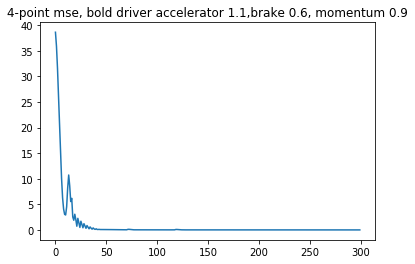

In [79]:
#test
y_interpolated,history = regress_signal(
    Sc_interpolated, N, J, learning_rate=100, 
    bold_driver_accelerator=1.1,
    bold_driver_brake=0.6,
    momentum=0.9, 
    NAG = False,
    n_iterations=300, 
    cost = "mse", 
    verbose=True)
plt.plot(history)
plt.title('4-point mse, bold driver accelerator 1.1,brake 0.6, momentum 0.9')

In [92]:
#vary accelerator
acc = [1.0,1.1,1.2,1.3,1.4]
final_val = []
for a in acc:
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=a,
        bold_driver_brake=0.6,
        momentum=0.9, 
        NAG = False,
        n_iterations=50, 
        cost = "mse", 
        verbose=True)
    final_val.append(history[-1])
fval = [float(v) for v in final_val]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

[0.15481366217136383, 0.09177541732788086, 0.10048945248126984, 0.5106804370880127, 0.18852145969867706]


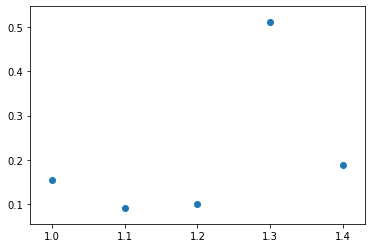

In [93]:
#fval = [float(v) for v in final_val]
print(fval)
plt.scatter(acc,fval)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

[0.09272633492946625, 0.08090159296989441, 0.0835956558585167, 0.26388758420944214, 0.059520184993743896, 0.08195529878139496, 0.43875789642333984]


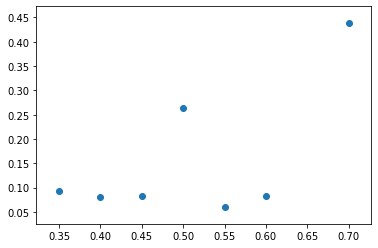

In [97]:
#vary brake
bra = [0.35,0.4,0.45,0.5,0.55,0.6,0.7]
final_val = []
for b in bra:
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=b,
        momentum=0.9, 
        NAG = False,
        n_iterations=50, 
        cost = "mse", 
        verbose=True)
    final_val.append(history[-1])
fval = [float(v) for v in final_val]
print(fval)
plt.scatter(bra,fval)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

[0.060533542186021805, 0.10552774369716644, 0.0971902385354042, 0.0795440748333931, 0.0661746934056282]


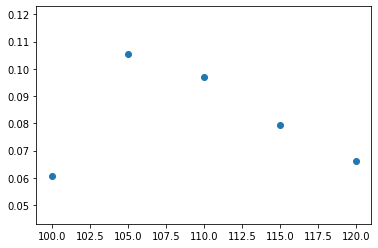

In [99]:
#vary learning rate
lea = [100, 105, 110, 115, 120]
final_val = []
for l in lea:
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=l, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.55,
        momentum=0.9, 
        NAG = False,
        n_iterations=50, 
        cost = "mse", 
        verbose=True)
    final_val.append(history[-1])
fval = [float(v) for v in final_val]
print(fval)
plt.scatter(lea,fval)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

[0.08855034410953522, 0.08720189332962036, 0.050553761422634125, 0.08731073886156082]


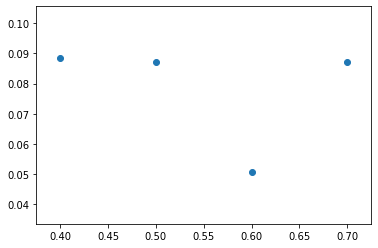

In [108]:
#vary momentum (not adaptive)
mom = [0.4,0.5,0.6,0.7]
final_val = []
for m in mom:
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.55,
        momentum=m, 
        NAG = False,
        n_iterations=50, 
        cost = "mse", 
        verbose=True)
    final_val.append(history[-1])
fval = [float(v) for v in final_val]
print(fval)
plt.scatter(mom,fval)

A Jupyter Widget

tensor(0.0209, grad_fn=<NormBackward0>)


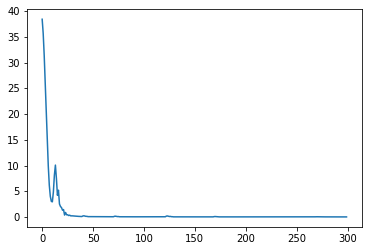

In [116]:
y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.55,
        momentum=0.0, 
        NAG = False,
        n_iterations=300, 
        cost = "mse", 
        verbose=True)
plt.plot(history)
print(history[-1])

## J choice

1. as j increases, recovered sounds have lower temporal resolution and better timbral resolution
2. j = 4 has the most timbral resolution that has acceptable temporal envelope.
3. generally the bigger j is, the bigger error there is after the regression recovers the sounds

In [136]:
Js = [2,3,4,5,6,7,8]
sounds_inter = []
for j in Js:
    print(j)
    J = j
    Sc_interpolated,sounds = interpolate_sounds(0.45,0.5,4,0.05,J)
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.55,
        momentum=0.0, 
        NAG = False,
        n_iterations=300, 
        cost = "mse", 
        verbose=True)
    print(history[-1])
    sounds_inter.append(y_interpolated)

2
--- 1.3476300239562988 seconds ---
--- 1.2309479713439941 seconds ---
--- 1.2480130195617676 seconds ---
--- 1.2416839599609375 seconds ---


A Jupyter Widget

tensor(0.0018, grad_fn=<NormBackward0>)
3
--- 1.6498761177062988 seconds ---
--- 1.6965019702911377 seconds ---
--- 2.0625059604644775 seconds ---
--- 1.929229974746704 seconds ---


A Jupyter Widget

tensor(0.0062, grad_fn=<NormBackward0>)
4
--- 1.6565918922424316 seconds ---
--- 1.642620325088501 seconds ---
--- 1.585705041885376 seconds ---
--- 1.6130480766296387 seconds ---


A Jupyter Widget

tensor(0.0121, grad_fn=<NormBackward0>)
5
--- 1.6614558696746826 seconds ---
--- 1.5879158973693848 seconds ---
--- 1.6288061141967773 seconds ---
--- 1.6053130626678467 seconds ---


A Jupyter Widget

tensor(0.0242, grad_fn=<NormBackward0>)
6
--- 1.5827889442443848 seconds ---
--- 1.5631060600280762 seconds ---
--- 1.5834150314331055 seconds ---
--- 1.5547010898590088 seconds ---


A Jupyter Widget

tensor(0.0448, grad_fn=<NormBackward0>)
7
--- 1.5741808414459229 seconds ---
--- 1.5388460159301758 seconds ---
--- 1.5240778923034668 seconds ---
--- 1.554805040359497 seconds ---


A Jupyter Widget

tensor(0.0279, grad_fn=<NormBackward0>)
8
--- 1.5762083530426025 seconds ---
--- 1.5139930248260498 seconds ---
--- 1.507713794708252 seconds ---
--- 1.552427053451538 seconds ---


A Jupyter Widget

tensor(0.0181, grad_fn=<NormBackward0>)


In [218]:
y = hitdifferentparts.hitdiffparts(0.45,0.5)
ipd.Audio(y,rate=44100)

--- 1.4543719291687012 seconds ---


In [137]:
for sound in sounds_inter:
    ipd.display(ipd.Audio(list(sound),rate=44100))

In [219]:
sounds_inter[1]

tensor([3.1949e-01, 2.5239e-01, 2.5830e-01,  ..., 2.1503e-04, 2.1522e-04,
        2.1386e-04], requires_grad=True)

In [220]:
y_true = hitdifferentparts.hitdiffparts(0.45,0.5)

--- 1.4051599502563477 seconds ---


In [221]:
y_inter = sounds_inter[1]

Text(0.5, 1.0, 'Time-Frequency spectrogram of signal')

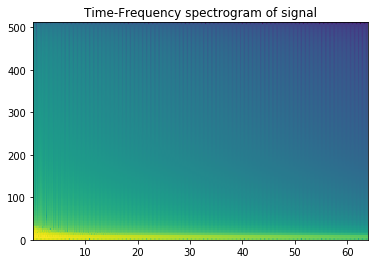

In [224]:
plt.figure()#figsize=(10, 10))
plt.specgram(y_true.ravel(), Fs=1024)
plt.title("Time-Frequency spectrogram of signal")

Text(0.5, 1.0, 'Time-Frequency spectrogram of interpolated signal')

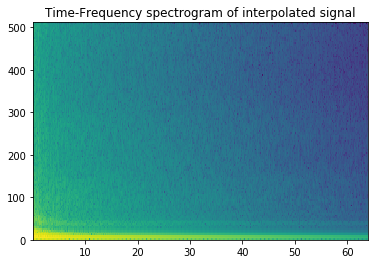

In [230]:
plt.figure()#figsize=(10, 10))
plt.specgram(sounds_inter[1].detach().numpy().ravel(), Fs=1024)
plt.title("Time-Frequency spectrogram of interpolated signal")

## cost function choice

## original + reconstructed from original + reconstructed from interpolation

20 points included, randomly sampled from 0.1 to 0.9

In [250]:
import random
import soundfile as sf

In [240]:
random.randint(1,20)

18

In [245]:
u1 = np.linspace(0.1,0.9,10)
pts=[]
for i in range(20):
    u = round(u1[random.randint(1,10)-1],2)
    v = round(u1[random.randint(1,10)-1],2)
    pts.append((u,v))
print(pts)

[(0.72, 0.9), (0.63, 0.9), (0.54, 0.19), (0.54, 0.37), (0.46, 0.54), (0.28, 0.28), (0.54, 0.37), (0.72, 0.54), (0.46, 0.81), (0.54, 0.28), (0.37, 0.46), (0.1, 0.19), (0.72, 0.46), (0.9, 0.1), (0.54, 0.81), (0.19, 0.28), (0.46, 0.54), (0.63, 0.46), (0.9, 0.54), (0.9, 0.81)]


In [252]:
for i,j in pts:
    print(str(i).split('.')[-1])

72
63
54
54
46
28
54
72
46
54
37
1
72
9
54
19
46
63
9
9


In [258]:
J

8

In [268]:
rate = 44100
J=7
for i,j in pts:
    y = hitdifferentparts.hitdiffparts(i,j)
    Sc = getsc(torch.Tensor(y),J)
    y_interpolated_original,history = regress_signal(
        Sc, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.6,
        momentum=0.9, 
        NAG = False,
        n_iterations=100, 
        cost = "mse", 
        verbose=True)
    Sc_interpolated,sounds = interpolate_sounds(i,j,4,0.05,J)
    y_interpolated,history = regress_signal(
        Sc_interpolated, N, J, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.6,
        momentum=0.9, 
        NAG = False,
        n_iterations=100, 
        cost = "mse", 
        verbose=True)
    ii = str(i).split('.')[-1]
    jj = str(j).split('.')[-1]
    sf.write("./reconstructed_sounds/"+ii+"_"+jj+"_"+str(J)+"_original"+".wav", y[:rate],rate)
    sf.write("./reconstructed_sounds/"+ii+"_"+jj+"_"+str(J)+"_r_original"+".wav", y_interpolated_original[:rate].detach().numpy(),rate)
    sf.write("./reconstructed_sounds/"+ii+"_"+jj+"_"+str(J)+"_r_interpolated"+".wav", y_interpolated[:rate].detach().numpy(),rate)
    

--- 1.6400370597839355 seconds ---


A Jupyter Widget

--- 1.523712158203125 seconds ---
--- 1.5315721035003662 seconds ---
--- 1.5160229206085205 seconds ---
--- 1.5272798538208008 seconds ---


A Jupyter Widget

--- 1.6231732368469238 seconds ---


A Jupyter Widget

--- 1.6401417255401611 seconds ---
--- 1.6018712520599365 seconds ---
--- 1.5970091819763184 seconds ---
--- 1.606212854385376 seconds ---


A Jupyter Widget

--- 1.7175588607788086 seconds ---


A Jupyter Widget

--- 1.6491458415985107 seconds ---
--- 1.8175568580627441 seconds ---
--- 1.6289761066436768 seconds ---
--- 1.6516180038452148 seconds ---


A Jupyter Widget

--- 1.903977870941162 seconds ---


A Jupyter Widget

--- 1.6427357196807861 seconds ---
--- 1.6136550903320312 seconds ---
--- 1.6217460632324219 seconds ---
--- 1.7558510303497314 seconds ---


A Jupyter Widget

--- 1.692112922668457 seconds ---


A Jupyter Widget

--- 1.8419270515441895 seconds ---
--- 1.7886903285980225 seconds ---
--- 1.7458820343017578 seconds ---
--- 1.9394989013671875 seconds ---


A Jupyter Widget

--- 1.6921401023864746 seconds ---


A Jupyter Widget

--- 1.6666550636291504 seconds ---
--- 1.6172809600830078 seconds ---
--- 1.7832059860229492 seconds ---
--- 1.7536356449127197 seconds ---


A Jupyter Widget

--- 1.964735984802246 seconds ---


A Jupyter Widget

--- 1.6391828060150146 seconds ---
--- 1.603105068206787 seconds ---
--- 1.5981249809265137 seconds ---
--- 1.5851569175720215 seconds ---


A Jupyter Widget

--- 1.8416190147399902 seconds ---


A Jupyter Widget

--- 1.6333000659942627 seconds ---
--- 1.609893798828125 seconds ---
--- 1.7620999813079834 seconds ---
--- 1.6655490398406982 seconds ---


A Jupyter Widget

--- 1.5989649295806885 seconds ---


A Jupyter Widget

--- 1.5914320945739746 seconds ---
--- 1.592602014541626 seconds ---
--- 1.5595557689666748 seconds ---
--- 1.5763211250305176 seconds ---


A Jupyter Widget

--- 1.830260992050171 seconds ---


A Jupyter Widget

--- 1.5985088348388672 seconds ---
--- 1.679703950881958 seconds ---
--- 2.0147182941436768 seconds ---
--- 1.8606257438659668 seconds ---


A Jupyter Widget

--- 2.0335628986358643 seconds ---


A Jupyter Widget

--- 1.7864060401916504 seconds ---
--- 1.8278367519378662 seconds ---
--- 2.2671360969543457 seconds ---
--- 1.5553839206695557 seconds ---


A Jupyter Widget

--- 1.767956018447876 seconds ---


A Jupyter Widget

--- 2.781201124191284 seconds ---
--- 1.65047287940979 seconds ---
--- 1.5848171710968018 seconds ---
--- 1.5765371322631836 seconds ---


A Jupyter Widget

--- 1.7317960262298584 seconds ---


A Jupyter Widget

--- 1.7741239070892334 seconds ---
--- 1.6159238815307617 seconds ---
--- 1.685089111328125 seconds ---
--- 1.6061038970947266 seconds ---


A Jupyter Widget

--- 1.7384881973266602 seconds ---


A Jupyter Widget

--- 1.7296268939971924 seconds ---
--- 1.6086630821228027 seconds ---
--- 1.699547290802002 seconds ---
--- 1.721282720565796 seconds ---


A Jupyter Widget

--- 1.7463150024414062 seconds ---


A Jupyter Widget

--- 1.8076422214508057 seconds ---
--- 1.9373953342437744 seconds ---
--- 2.22499418258667 seconds ---
--- 1.9621849060058594 seconds ---


A Jupyter Widget

--- 1.6310009956359863 seconds ---


A Jupyter Widget

--- 1.5594861507415771 seconds ---
--- 1.573864221572876 seconds ---
--- 1.5395009517669678 seconds ---
--- 1.5582561492919922 seconds ---


A Jupyter Widget

--- 1.6712801456451416 seconds ---


A Jupyter Widget

--- 1.6871860027313232 seconds ---
--- 1.8106889724731445 seconds ---
--- 1.8372690677642822 seconds ---
--- 1.5588963031768799 seconds ---


A Jupyter Widget

--- 1.6435701847076416 seconds ---


A Jupyter Widget

--- 1.5922110080718994 seconds ---
--- 1.5787162780761719 seconds ---
--- 1.518442153930664 seconds ---
--- 1.5850129127502441 seconds ---


A Jupyter Widget

--- 1.871189832687378 seconds ---


A Jupyter Widget

--- 2.917081117630005 seconds ---
--- 1.7164840698242188 seconds ---
--- 1.6008491516113281 seconds ---
--- 1.5754430294036865 seconds ---


A Jupyter Widget

--- 1.6249480247497559 seconds ---


A Jupyter Widget

--- 1.5549147129058838 seconds ---
--- 1.5671641826629639 seconds ---
--- 1.5556278228759766 seconds ---
--- 1.5392727851867676 seconds ---


A Jupyter Widget